try spectral clustering

In [ ]:
#weights and bias connect
import os
import wandb
from getpass import getpass
!pip install wandb
from google.colab import userdata
userdata.get('WandB')
WANDB_PROJECT='Georgia-Frog-Identification'
WANDB_ENTITY='hikesofgeorgia-hikes-of-georgia-llc'

os.environ["WANDB_API_KEY"] = getpass("Enter your W&B API key: ")
wandb.login()

Enter your W&B API key: ··········


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: hikesofgeorgia (hikesofgeorgia-hikes-of-georgia-llc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import os

directory_path = '/content/drive/MyDrive/spectrograms'
if os.path.isdir(directory_path):
    print("Contents of the directory:")
    for item in os.listdir(directory_path):
        print(item)
else:
    print(f"Error: {directory_path} is not a valid directory.")

Contents of the directory:
american_bullfrog
american_toad
bird_voiced_tree_frog
copes_gray_treefrog
eastern_spadefoot_toad
eastern_narrow_mouthed_toad
green_frog
fowlers_toad
green_tree_frog
northern_cricket_frog
not_frogs
pickerel_frog
preview
spring_peeper
upland_chorus_frog
southern_leopard_frog


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os
import numpy as np # Import numpy
import torch.nn.functional as F # Import functional for tensor transforms

class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the class subdirectories.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.classes = sorted([d.name for d in os.scandir(root_dir) if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                # Check for .npy file extension
                if filename.endswith('.npy'):
                    self.image_files.append(os.path.join(class_dir, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_files[idx]
        # Load .npy file using numpy
        spectrogram = np.load(img_path)

        # Convert numpy array to torch tensor. Assuming the shape is (height, width)
        # and needs to be (channels, height, width) and data type is float32
        image = torch.from_numpy(spectrogram).unsqueeze(0).float()


        label = self.labels[idx]

        if self.transform:
            # Apply transforms that work on tensors
            image = self.transform(image)

        return image, label

def normalize_tensor(tensor):
    """
    Normalize a tensor to have values between 0 and 1.
    """
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    return (tensor - tensor_min) / (tensor_max - tensor_min + 1e-8)

def standardize_tensor(tensor):
    """
    Standardize a tensor to have zero mean and unit variance.
    """
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / (std + 1e-8)

def resize_tensor(tensor, size):
    """
    Resize a tensor to the specified size.
    """
    return F.interpolate(tensor.unsqueeze(0), size=size, mode='bilinear', align_corners=False).squeeze(0)

transform =  transforms.Compose([
    transforms.Lambda(lambda x: resize_tensor(x, (128, 128))),
    transforms.Lambda(lambda x: normalize_tensor(x)),
])

dataset = SpectrogramDataset(root_dir='/content/drive/MyDrive/spectrograms', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Class Distribution:
  american_bullfrog: 123 samples (8.8%)
  american_toad: 183 samples (13.1%)
  bird_voiced_tree_frog: 27 samples (1.9%)
  copes_gray_treefrog: 137 samples (9.8%)
  eastern_narrow_mouthed_toad: 97 samples (6.9%)
  eastern_spadefoot_toad: 17 samples (1.2%)
  fowlers_toad: 40 samples (2.9%)
  green_frog: 84 samples (6.0%)
  green_tree_frog: 180 samples (12.9%)
  northern_cricket_frog: 164 samples (11.7%)
  not_frogs: 117 samples (8.4%)
  pickerel_frog: 57 samples (4.1%)
  preview: 0 samples (0.0%)
  southern_leopard_frog: 36 samples (2.6%)
  spring_peeper: 106 samples (7.6%)
  upland_chorus_frog: 32 samples (2.3%)


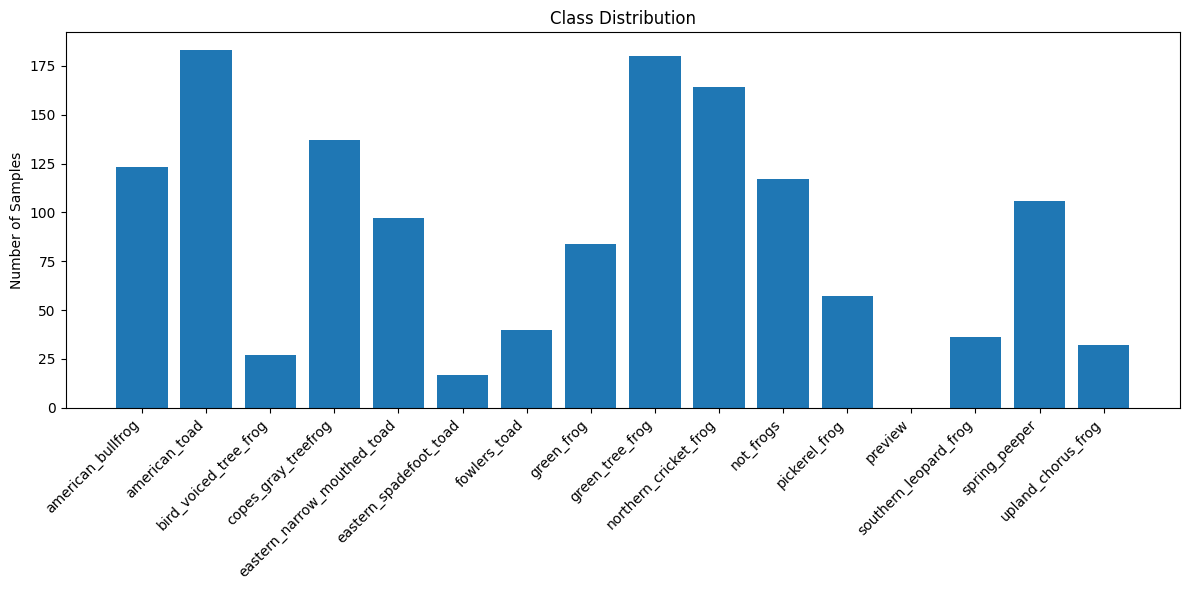

In [ ]:
import matplotlib.pyplot as plt
import collections

def analyze_class_distribution(dataset):
    """Analyze and visualize class distribution"""
    class_counts = collections.Counter(dataset.labels)
    class_names = dataset.classes

    print("Class Distribution:")
    for i, class_name in enumerate(class_names):
        count = class_counts[i]
        print(f"  {class_name}: {count} samples ({count/len(dataset)*100:.1f}%)")

    # Plot distribution
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, [class_counts[i] for i in range(len(class_names))])
    plt.xticks(rotation=45, ha='right')
    plt.title('Class Distribution')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()

    return class_counts

# Analyze your dataset
class_counts = analyze_class_distribution(dataset)

In [ ]:
from numpy.random.mtrand import sample
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import WeightedRandomSampler

# Get the labels from the dataset
labels = [label for _, label in dataset]
labels = np.array(labels) # Convert to numpy array for sklearn

# First, split into training and a temporary set (which will then be split into validation and test)
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    np.arange(len(dataset)),
    labels,
    test_size=0.3, # 30% for temp (validation + test)
    stratify=labels,
    random_state=42 # for reproducibility
)

# Now, split the temporary set into validation and test (50/50 split of the temp_indices)
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5, # 15% validation, 15% test (0.5 * 30% = 15%)
    stratify=temp_labels,
    random_state=42 # for reproducibility
)
# Create Subset datasets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)


def create_weighted_sampler(dataset, indices):
    # Create weighted sampler to handle class imbalance
    labels = []
    for i in indices:
        _, label = dataset[i]  # Get the (image, label) tuple and extract just the label
        labels.append(label)

    # Get weights
    class_counts = np.bincount(labels)
    class_weights = 1. / np.sqrt(class_counts + 1e-8)
    sample_weights = class_weights[labels]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

train_sampler = create_weighted_sampler(dataset, train_indices)

# Create DataLoaders add sampler
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Optional: Verify stratification (print class distribution in train, validation, and test sets)
print("\nTraining set class distribution:")
unique_train_labels, counts_train = np.unique(labels[train_indices], return_counts=True)
print(dict(zip(unique_train_labels, counts_train)))

print("\nValidation set class distribution:")
unique_val_labels, counts_val = np.unique(labels[val_indices], return_counts=True)
print(dict(zip(unique_val_labels, counts_val)))

print("\nTesting set class distribution:")
unique_test_labels, counts_test = np.unique(labels[test_indices], return_counts=True)
print(dict(zip(unique_test_labels, counts_test)))



Training dataset size: 980
Validation dataset size: 210
Testing dataset size: 210

Training set class distribution:
{np.int64(0): np.int64(86), np.int64(1): np.int64(128), np.int64(2): np.int64(19), np.int64(3): np.int64(96), np.int64(4): np.int64(68), np.int64(5): np.int64(12), np.int64(6): np.int64(28), np.int64(7): np.int64(59), np.int64(8): np.int64(126), np.int64(9): np.int64(115), np.int64(10): np.int64(82), np.int64(11): np.int64(40), np.int64(13): np.int64(25), np.int64(14): np.int64(74), np.int64(15): np.int64(22)}

Validation set class distribution:
{np.int64(0): np.int64(19), np.int64(1): np.int64(28), np.int64(2): np.int64(4), np.int64(3): np.int64(20), np.int64(4): np.int64(15), np.int64(5): np.int64(2), np.int64(6): np.int64(6), np.int64(7): np.int64(12), np.int64(8): np.int64(27), np.int64(9): np.int64(25), np.int64(10): np.int64(17), np.int64(11): np.int64(9), np.int64(13): np.int64(5), np.int64(14): np.int64(16), np.int64(15): np.int64(5)}

Testing set class distributi

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedLightCNN(nn.Module):
    def __init__(self, num_classes=16, input_channels=1, dropout_rate=0.5):
        super(ImprovedLightCNN, self).__init__()


        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.3)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout2d(0.4)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.pool4 = nn.AdaptiveAvgPool2d((1,1))

        #classifier enhanced extra layer
        self.dropout_fc = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc = nn.BatchNorm1d(256)
        self.fc = nn.Linear(256, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)

        x= x.view(x.size(0), -1)
        x = self.dropout_fc(x)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.fc(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImprovedLightCNN(num_classes=len(dataset.classes), input_channels=1, dropout_rate=0.5).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.9, 0.999))

criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=25, steps_per_epoch=len(train_loader), pct_start=0.3, div_factor=10.0, final_div_factor=100.0, anneal_strategy='cos')

print(" Starting training with Higher LR + OneCycleLR...")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Max LR: 0.01, Base LR: 0.002")

# Initialize Weights & Biases run
wandb.init(project=WANDB_PROJECT, entity=WANDB_ENTITY, reinit='finish_previous')

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
learning_rates = []

best_val_acc = 0.0
patience = 8
patience_counter = 0


for epoch in range(25):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    epoch_lrs = []

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        #add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        epoch_lrs.append(current_lr)

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_predictions / total_predictions
    avg_lr = np.mean(epoch_lrs)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    learning_rates.append(avg_lr)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total_predictions += labels.size(0)
            val_correct_predictions += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_correct_predictions / val_total_predictions

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    #early stopping
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best validation accuracy: {val_epoch_acc:.4f}")
    else:
        patience_counter += 1


    print(f"Epoch [{epoch+1}/25], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, Avg LR: {avg_lr:.6f}, patience: {patience_counter}/{patience}")

    # Log metrics to Weights & Biases
    wandb.log({"epoch": epoch + 1, "train_loss": epoch_loss, "train_accuracy": epoch_acc, "val_loss": val_epoch_loss, "val_accuracy": val_epoch_acc, "learning_rate": avg_lr, "best_val_accuracy": best_val_acc})
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

print(f"Training complete! Best validation accuracy: {best_val_acc:.4f}")

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(learning_rates)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.subplot(1, 3, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Finish the Weights & Biases run
wandb.finish()

 Starting training with Higher LR + OneCycleLR...
Model parameters: 4,824,016
Max LR: 0.01, Base LR: 0.002


New best validation accuracy: 0.1333
Epoch [1/25], Train Loss: 2.5627, Train Acc: 0.1878, Val Loss: 2.6897, Val Acc: 0.1333, Avg LR: 0.001138, patience: 0/8
New best validation accuracy: 0.2571
Epoch [2/25], Train Loss: 2.2859, Train Acc: 0.2561, Val Loss: 3.1330, Val Acc: 0.2571, Avg LR: 0.001911, patience: 0/8
New best validation accuracy: 0.2667
Epoch [3/25], Train Loss: 2.3618, Train Acc: 0.2418, Val Loss: 2.6549, Val Acc: 0.2667, Avg LR: 0.003310, patience: 0/8
Epoch [4/25], Train Loss: 2.2569, Train Acc: 0.3020, Val Loss: 3.5707, Val Acc: 0.2238, Avg LR: 0.005091, patience: 1/8
New best validation accuracy: 0.3143
Epoch [5/25], Train Loss: 2.2577, Train Acc: 0.2898, Val Loss: 2.3690, Val Acc: 0.3143, Avg LR: 0.006944, patience: 0/8
Epoch [6/25], Train Loss: 2.3489, Train Acc: 0.2612, Val Loss: 2.1985, Val Acc: 0.2810, Avg LR: 0.008544, patience: 1/8
New best validation accuracy: 0.4619
Epoch [7/25], Train Loss: 2.1923, Train Acc: 0.3214, Val Loss: 1.9645, Val Acc: 0.4619, Avg LR:

In [14]:
def analyze_model_performance(model, train_loader, val_loader, device):
    """Analyze model performance and predictions"""
    model.eval()

    # Training set predictions
    train_correct = 0
    train_total = 0
    train_confidences = []

    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probabilities, 1)

            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_confidences.extend(max_probs.cpu().tolist())

    train_acc = train_correct / train_total

    # Validation set predictions
    val_correct = 0
    val_total = 0
    val_confidences = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probabilities, 1)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_confidences.extend(max_probs.cpu().tolist())

    val_acc = val_correct / val_total

    print(f"\n📊 Model Performance Analysis:")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Training Confidence - Mean: {np.mean(train_confidences):.3f}, Std: {np.std(train_confidences):.3f}")
    print(f"Validation Confidence - Mean: {np.mean(val_confidences):.3f}, Std: {np.std(val_confidences):.3f}")

    return train_acc, val_acc

# Run analysis after training
print("\n" + "="*50)
print("FINAL MODEL ANALYSIS")
print("="*50)
train_acc, val_acc = analyze_model_performance(model, train_loader, val_loader, device)


FINAL MODEL ANALYSIS

📊 Model Performance Analysis:
Training Accuracy: 0.5714
Validation Accuracy: 0.5714
Training Confidence - Mean: 0.526, Std: 0.247
Validation Confidence - Mean: 0.544, Std: 0.254


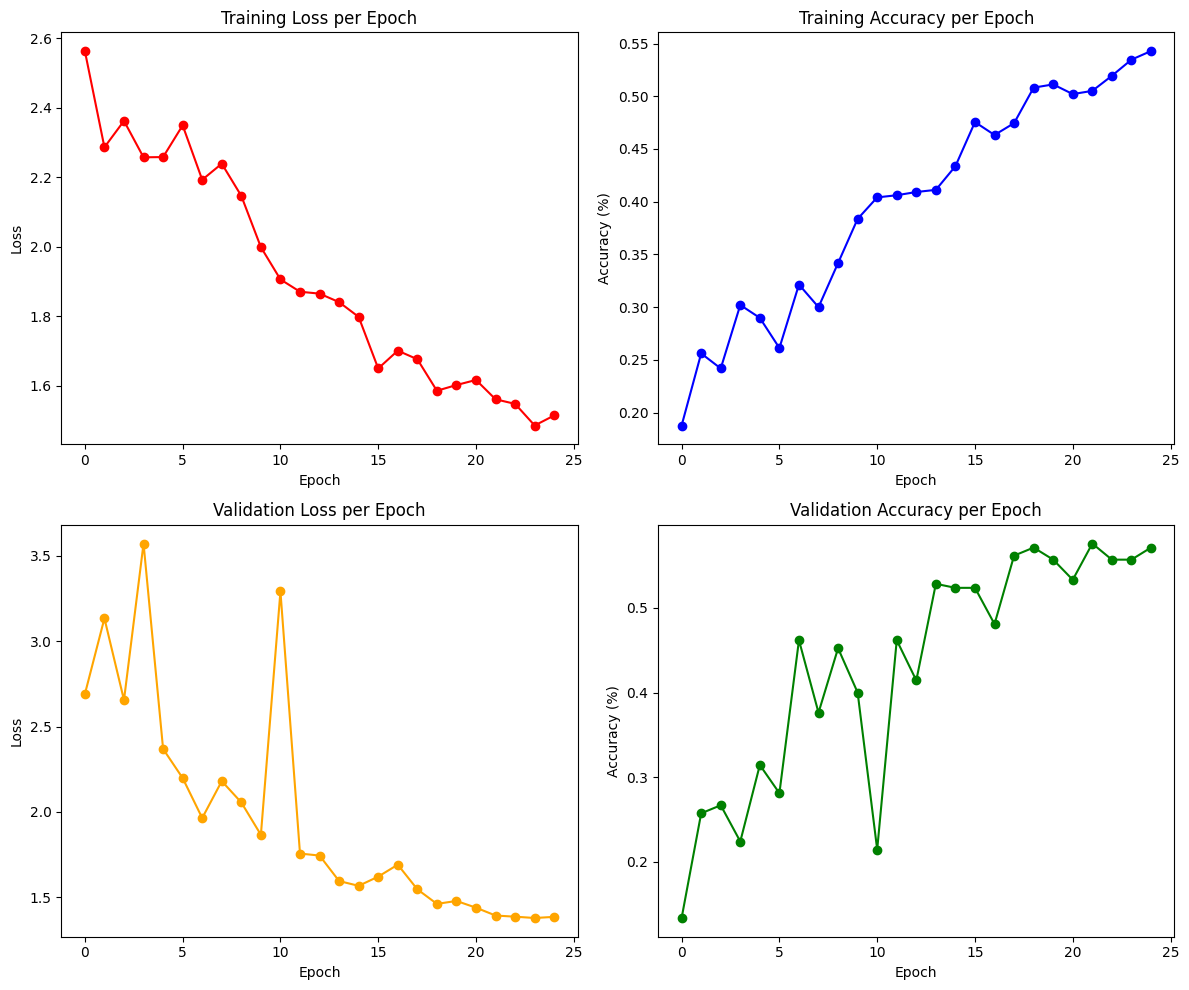

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses, 'o-', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, 'o-', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.subplot(2, 2, 3)
plt.plot(val_losses, 'o-', color='orange')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(val_accuracies, 'o-', color='green')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

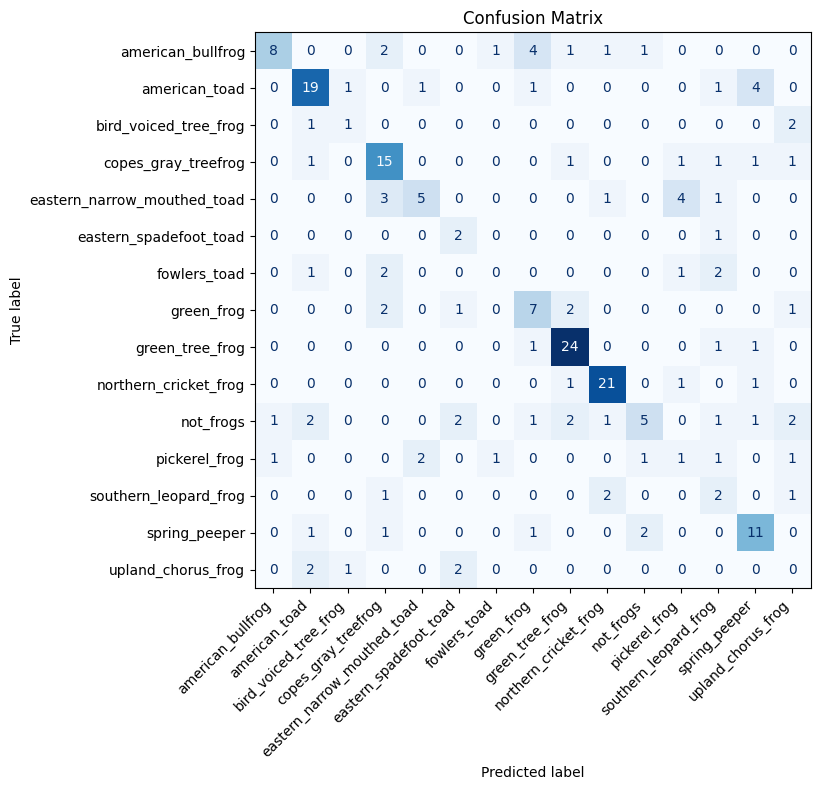

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Get unique labels from the true and predicted values
unique_labels = np.unique(np.concatenate((y_true, y_pred)))

# Generate confusion matrix using only the unique labels
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

# Get the class names corresponding to the unique labels
display_class_labels = [dataset.classes[i] for i in unique_labels]

# Create ConfusionMatrixDisplay with the confusion matrix and corresponding class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_class_labels)

# Get the axes object from the plot
fig, ax = plt.subplots(figsize=(10, 8)) # You can adjust the figure size as needed
disp.plot(ax=ax, cmap='Blues', colorbar=False) # Add cmap here

# Explicitly set ticks and labels using the display_class_labels
num_unique_classes = len(unique_labels)
ax.set_xticks(np.arange(num_unique_classes))
ax.set_yticks(np.arange(num_unique_classes))
ax.set_xticklabels(display_class_labels, rotation=45, ha="right")
ax.set_yticklabels(display_class_labels)


plt.title("Confusion Matrix")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [ ]:
print("Sample batch stats:")
images, labels = next(iter(train_loader))
print(f"Image shape: {images.shape}")
print(f"Label distribution in batch: {torch.bincount(labels)}")
print(f"Data range: [{images.min():.3f}, {images.max():.3f}]")

# Task
Explain how to push a Colab notebook to GitHub.